## Random Initialization Approach

- The Random Initialization Approach is a technique used in training neural network models, particularly in the context of image classification tasks. In this approach, the parameters of the neural network are initialized randomly before the training process begins. The main idea behind random initialization is to break the symmetry and provide the network with diverse starting points, enabling it to learn more effectively during training.

- When a neural network is created, its parameters, including weights and biases, need to be initialized with some initial values. In contrast to other initialization methods that assign specific values based on heuristics or pre-trained models, random initialization assigns random values within a defined range to each parameter. This means that the initial weights and biases are not biased towards any particular direction or pattern, allowing the network to explore various paths during optimization.

- Random initialization has several advantages. Firstly, it helps to prevent all neurons from learning the same features simultaneously, which can result in suboptimal solutions. By providing diverse initial values, random initialization encourages different neurons to specialize in different features or patterns, leading to more robust and effective representations.

- Secondly, random initialization helps to escape local optima during the optimization process. Neural networks are trained using optimization algorithms like gradient descent, which aim to find the global minimum of the loss function. However, the loss landscape of deep neural networks is highly complex and often contains many local minima. Randomly initializing the parameters ensures that the optimization process explores different regions of the loss landscape, increasing the chances of finding better solutions.

- Lastly, random initialization reduces the dependence on pre-trained models or prior knowledge. By starting from random values, the network is not biased towards any specific task or dataset, making it more adaptable and flexible. This is particularly useful in scenarios where pre-trained models may not be available or relevant.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from skimage import color
import random

In [2]:
num_epochs = random.randint(50, 100)
my_list = [512]
batch_size = random.choice(my_list)
learning_rate = 1e-3
use_gpu = True
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("num_epochs:" + str(num_epochs))
print("batch_size:" + str(batch_size))

Using cuda device
num_epochs:69
batch_size:512


In [3]:
class Net(nn.Module):
    def __init__(self, d=128):
        super(Net, self).__init__()
            
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2),
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2)
            )

        self.conv_stack = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),
        )

        # Randomly initialize the parameters
        self.initialize_parameters()

    def initialize_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.zeros_(module.bias)

    def forward(self, input):
        x = self.encoder(input)
        x = self.conv_stack(x)
        x = self.decoder(x)
        return x

Here with have the network where we are gone get the encoder.

In [4]:
class RandomAproach(nn.Module):
    def __init__(self, color_net, num_classes=10):
        super(RandomAproach, self).__init__()
        self.color_net = color_net.encoder
        self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.classifier = nn.Linear(128 * 4 * 4, num_classes)

        # Randomly initialize the parameters
        self.initialize_parameters()

    def initialize_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, input):
        x = self.color_net(input[:, :1, :, :])  # Pass only the first channel to color_net.encoder
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.dropout2(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
net = Net()

model = RandomAproach(net, num_classes=10).to(device)

Here we have the model with random approach, being random initialized with the function initialize_parameters.

In [5]:
def import_image(img):
    return torch.FloatTensor(np.expand_dims(color.rgb2(np.array(img)), axis=0))

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 80333901.33it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [6]:
indices = list(range(len(test_dataset)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(test_dataset, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [7]:
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [9]:
num_epochs = 25
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 97/97 [00:12<00:00,  7.69it/s]


Train loss: 1.875 	 Train acc: 0.312


100%|██████████| 16/16 [00:01<00:00, 14.02it/s]


Val loss: 1.652 	 Val acc: 0.395

Epoch 2


100%|██████████| 97/97 [00:07<00:00, 12.83it/s]


Train loss: 1.491 	 Train acc: 0.465


100%|██████████| 16/16 [00:01<00:00, 12.94it/s]


Val loss: 1.690 	 Val acc: 0.423

Epoch 3


100%|██████████| 97/97 [00:06<00:00, 13.89it/s]


Train loss: 1.284 	 Train acc: 0.545


100%|██████████| 16/16 [00:01<00:00, 14.34it/s]


Val loss: 1.290 	 Val acc: 0.549

Epoch 4


100%|██████████| 97/97 [00:07<00:00, 13.39it/s]


Train loss: 1.152 	 Train acc: 0.595


100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


Val loss: 1.149 	 Val acc: 0.593

Epoch 5


100%|██████████| 97/97 [00:07<00:00, 13.72it/s]


Train loss: 1.047 	 Train acc: 0.631


100%|██████████| 16/16 [00:01<00:00,  8.92it/s]


Val loss: 1.080 	 Val acc: 0.615

Epoch 6


100%|██████████| 97/97 [00:07<00:00, 13.39it/s]


Train loss: 0.968 	 Train acc: 0.660


100%|██████████| 16/16 [00:01<00:00, 13.43it/s]


Val loss: 1.242 	 Val acc: 0.579

Epoch 7


100%|██████████| 97/97 [00:06<00:00, 14.93it/s]


Train loss: 0.896 	 Train acc: 0.688


100%|██████████| 16/16 [00:01<00:00, 14.30it/s]


Val loss: 1.041 	 Val acc: 0.639

Epoch 8


100%|██████████| 97/97 [00:06<00:00, 14.56it/s]


Train loss: 0.831 	 Train acc: 0.708


100%|██████████| 16/16 [00:01<00:00, 13.41it/s]


Val loss: 0.991 	 Val acc: 0.653

Epoch 9


100%|██████████| 97/97 [00:06<00:00, 14.45it/s]


Train loss: 0.792 	 Train acc: 0.721


100%|██████████| 16/16 [00:01<00:00, 13.99it/s]


Val loss: 1.164 	 Val acc: 0.617

Epoch 10


100%|██████████| 97/97 [00:07<00:00, 13.16it/s]


Train loss: 0.744 	 Train acc: 0.740


100%|██████████| 16/16 [00:01<00:00, 14.13it/s]


Val loss: 0.911 	 Val acc: 0.687

Epoch 11


100%|██████████| 97/97 [00:06<00:00, 14.93it/s]


Train loss: 0.698 	 Train acc: 0.755


100%|██████████| 16/16 [00:01<00:00, 13.15it/s]


Val loss: 0.968 	 Val acc: 0.669

Epoch 12


100%|██████████| 97/97 [00:06<00:00, 14.36it/s]


Train loss: 0.667 	 Train acc: 0.766


100%|██████████| 16/16 [00:01<00:00, 13.89it/s]


Val loss: 0.958 	 Val acc: 0.682

Epoch 13


100%|██████████| 97/97 [00:06<00:00, 14.37it/s]


Train loss: 0.638 	 Train acc: 0.777


100%|██████████| 16/16 [00:01<00:00, 10.30it/s]


Val loss: 1.077 	 Val acc: 0.650

Epoch 14


100%|██████████| 97/97 [00:06<00:00, 14.24it/s]


Train loss: 0.603 	 Train acc: 0.786


100%|██████████| 16/16 [00:01<00:00, 11.56it/s]


Val loss: 1.001 	 Val acc: 0.672

Epoch 15


100%|██████████| 97/97 [00:07<00:00, 12.28it/s]


Train loss: 0.566 	 Train acc: 0.800


100%|██████████| 16/16 [00:01<00:00, 13.90it/s]


Val loss: 0.937 	 Val acc: 0.690

Epoch 16


100%|██████████| 97/97 [00:06<00:00, 14.23it/s]


Train loss: 0.542 	 Train acc: 0.808


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


Val loss: 0.935 	 Val acc: 0.706

Epoch 17


100%|██████████| 97/97 [00:07<00:00, 13.45it/s]


Train loss: 0.519 	 Train acc: 0.817


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


Val loss: 1.085 	 Val acc: 0.663

Epoch 18


100%|██████████| 97/97 [00:06<00:00, 15.01it/s]


Train loss: 0.487 	 Train acc: 0.828


100%|██████████| 16/16 [00:01<00:00, 13.00it/s]


Val loss: 1.279 	 Val acc: 0.636

Epoch 19


100%|██████████| 97/97 [00:06<00:00, 14.66it/s]


Train loss: 0.471 	 Train acc: 0.831


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


Val loss: 1.053 	 Val acc: 0.685

Epoch 20


100%|██████████| 97/97 [00:06<00:00, 14.39it/s]


Train loss: 0.455 	 Train acc: 0.836


100%|██████████| 16/16 [00:01<00:00, 13.95it/s]


Val loss: 1.248 	 Val acc: 0.654

Epoch 21


100%|██████████| 97/97 [00:07<00:00, 13.31it/s]


Train loss: 0.433 	 Train acc: 0.845


100%|██████████| 16/16 [00:01<00:00, 14.30it/s]


Val loss: 1.148 	 Val acc: 0.658

Epoch 22


100%|██████████| 97/97 [00:06<00:00, 15.13it/s]


Train loss: 0.409 	 Train acc: 0.854


100%|██████████| 16/16 [00:01<00:00, 12.40it/s]


Val loss: 0.944 	 Val acc: 0.707

Epoch 23


100%|██████████| 97/97 [00:06<00:00, 14.92it/s]


Train loss: 0.397 	 Train acc: 0.858


100%|██████████| 16/16 [00:01<00:00, 13.61it/s]


Val loss: 1.003 	 Val acc: 0.707

Epoch 24


100%|██████████| 97/97 [00:06<00:00, 14.25it/s]


Train loss: 0.368 	 Train acc: 0.867


100%|██████████| 16/16 [00:01<00:00, 13.95it/s]


Val loss: 1.131 	 Val acc: 0.686

Epoch 25


100%|██████████| 97/97 [00:07<00:00, 13.12it/s]


Train loss: 0.357 	 Train acc: 0.871


100%|██████████| 16/16 [00:01<00:00, 13.95it/s]


Val loss: 1.431 	 Val acc: 0.648
Finished


Here we trained our model with a number of 25 epochs, achieving good results.

In [10]:
def show_errors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
        if ind >= num_examples:
            break
        X, y = X.to(device), y.to(device)    
        pred = model(X)
        probs = F.softmax(pred, dim=1)
        final_pred = torch.argmax(probs, dim=1)

        plt.subplot(10, 10, ind + 1)
        plt.axis("off")
        plt.text(0, -1, str(y[0].item()), fontsize=14, color='green')  # correct
        plt.text(8, -1, str(final_pred[0].item()), fontsize=14, color='red')  # predicted

        image = np.transpose(X[0].cpu().numpy(), (1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions

        if image.shape[-1] == 1:  # If the image is grayscale, convert to RGB
            image = np.squeeze(image)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)

    plt.show()

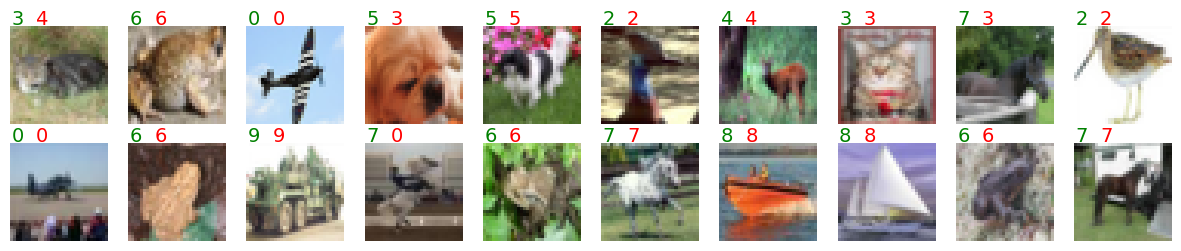

In [11]:
show_errors(model, test_dataloader)

Here we can see the final product each image, its true value and the guess that was made.

In [12]:
def plot_training_history(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

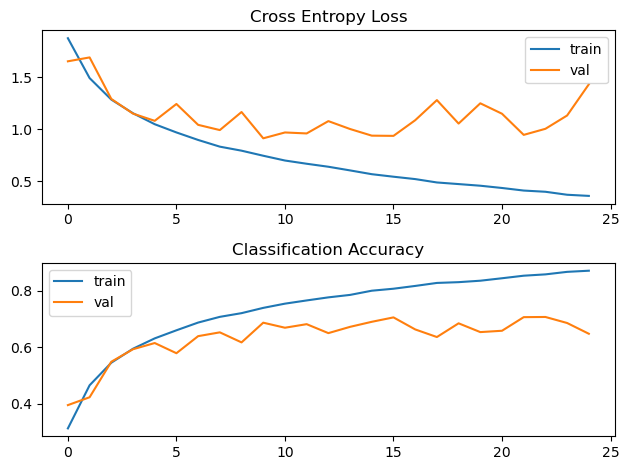

In [13]:
plot_training_history(train_history, val_history)

Here, finnally, we see in these graphics the classification accuracy and cross entropy loss.